In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
vocabulary_size = 10000
num_tags = 100
num_departments = 4

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

### 서브클래싱한 모델을 포함하는 함수형 모델

In [2]:
class Classifier(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
        self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features) #output 서브클래싱
model = keras.Model(inputs=inputs, outputs=outputs)

### 함수형 모델을 포함하는 서브클래싱 모델

In [3]:
inputs = keras.Input(shape=(64,))#함수형
outputs = layers.Dense(1, activation="sigmoid")(inputs) #함수형
binary_classifier = keras.Model(inputs=inputs, outputs=outputs) 

class MyModel(keras.Model): #서브클래싱

    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()

# 내장된 훈련 루프와 평가 루프 사용하기

### 표준 워크플로: compile(), fit(), evaluate(), predict()

In [4]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 12s 7ms/step - loss: 0.2942 - accuracy: 0.9129 - val_loss: 0.1487 - val_accuracy: 0.9577
Epoch 2/3
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1639 - accuracy: 0.9542 - val_loss: 0.1332 - val_accuracy: 0.9631
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1127 - accuracy: 0.9722


# 사용자 정의 지표 구하기

In [5]:
import tensorflow as tf
class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")#샘플 수 저장

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1]) #실제 레이블 원핫 인코딩
        mse = tf.reduce_sum(tf.square(y_true - y_pred)) #차이 제곱 mse 
        self.mse_sum.assign_add(mse) # MSE 값을 mse_sum에 누적
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        #전체 샘플에 대한 평균 제곱 오차(MSE)를 계산하고, 그 제곱근을 반환
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [6]:

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2989 - accuracy: 0.9124 - rmse: 7.1818 - val_loss: 0.1449 - val_accuracy: 0.9595 - val_rmse: 7.3624
Epoch 2/3
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1661 - accuracy: 0.9520 - rmse: 7.3537 - val_loss: 0.1228 - val_accuracy: 0.9672 - val_rmse: 7.4004
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1032 - accuracy: 0.9731 - rmse: 7.4374


# 콜백 사용하기

### EarlyStopping 콜백과 ModelCheckpoint 콜백

**fit() 메서드에서 callbacks 매개변수 사용하기**

In [8]:
callbacks_list = [
    keras.callbacks.EarlyStopping( #성능향상이 멈추면 중지
        monitor="val_accuracy",#정확도 모니터링
        patience=2,#2번 epoch기준
    ),
    keras.callbacks.ModelCheckpoint(#epoch끝에서 현재 가중치 저장
        filepath="checkpoint_path.h5",#파일 저장경로
        monitor="val_loss",
        save_best_only=True,#모델 성능이 좋아지지 않으면 덮어쓰지 않음
    )
]
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])#정확도 모델 지표
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2965 - accuracy: 0.9120 - val_loss: 0.1537 - val_accuracy: 0.9550
Epoch 2/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1657 - accuracy: 0.9537 - val_loss: 0.1241 - val_accuracy: 0.9659
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1438 - accuracy: 0.9622 - val_loss: 0.1211 - val_accuracy: 0.9697
Epoch 4/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1279 - accuracy: 0.9670 - val_loss: 0.1224 - val_accuracy: 0.9710
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1189 - accuracy: 0.9710 - val_loss: 0.1084 - val_accuracy: 0.9737
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1106 - accuracy: 0.9726 - val_loss: 0.1120 - val_accuracy: 0.9763
Epoch 7/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1061 - accuracy: 0.9754 - val_loss: 0.1109 - val_ac

In [9]:
model = keras.models.load_model("checkpoint_path.h5") #모델 저장

### 사용자 정의 콜백 만들기

**Callback 클래스를 상속하여 사용자 정의 콜백 만들기**

In [11]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs): #훈련이 시작할때
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):#배치처리 끝
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):#에포크끝
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Epoch 1/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2942 - accuracy: 0.9131 - val_loss: 0.1482 - val_accuracy: 0.9584
Epoch 2/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1646 - accuracy: 0.9529 - val_loss: 0.1224 - val_accuracy: 0.9663
Epoch 3/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1383 - accuracy: 0.9620 - val_loss: 0.1181 - val_accuracy: 0.9709
Epoch 4/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1251 - accuracy: 0.9666 - val_loss: 0.1081 - val_accuracy: 0.9734
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1192 - accuracy: 0.9704 - val_loss: 0.1032 - val_accuracy: 0.9760
Epoch 6/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1076 - accuracy: 0.9736 - val_loss: 0.1046 - val_accuracy: 0.9776
Epoch 7/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1034 - accuracy: 0.9747 - val_loss: 0.1153 - val_ac

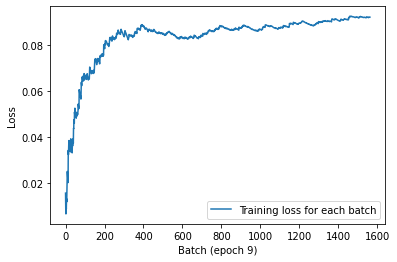

In [12]:

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

### 텐서보드를 사용한 모니터링과 시각화

In [13]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(
    log_dir="./tb_logs",
)
model.fit(train_images, train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

Epoch 1/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2912 - accuracy: 0.9141 - val_loss: 0.1444 - val_accuracy: 0.9589
Epoch 2/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1615 - accuracy: 0.9545 - val_loss: 0.1162 - val_accuracy: 0.9679
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1355 - accuracy: 0.9628 - val_loss: 0.1131 - val_accuracy: 0.9696
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1227 - accuracy: 0.9681 - val_loss: 0.1169 - val_accuracy: 0.9727
Epoch 5/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1149 - accuracy: 0.9715 - val_loss: 0.1122 - val_accuracy: 0.9755
Epoch 6/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1105 - accuracy: 0.9735 - val_loss: 0.1099 - val_accuracy: 0.9774
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1042 - accuracy: 0.9754 - val_loss: 0.1150 - val_ac

# 사용자 정의 훈련, 평가 루프 만들기

### 측정 지표의 저수준 사용법

In [14]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"결과: {current_result:.2f}")

결과: 1.00


In [15]:

values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"평균 지표: {mean_tracker.result():.2f}")

평균 지표: 2.00


### 완전한 훈련과 평가 루프

**단계별 훈련 루프 작성하기: 훈련 스텝 함수**

In [22]:
def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))  # 입력층: 28x28 픽셀 이미지를 784개의 숫자로 펼쳐서 받음
    features = layers.Dense(512, activation="relu")(inputs)  # 은닉층: 512개의 뉴런, ReLU 활성화 함수 사용
    features = layers.Dropout(0.5)(features)  # 드롭아웃: 훈련 중에 50% 뉴런을 랜덤하게 꺼서 과적합 방지
    outputs = layers.Dense(10, activation="softmax")(features)  # 출력층: 10개의 뉴런, 각 숫자 클래스에 대한 확률 출력
    model = keras.Model(inputs, outputs)  # 입력층과 출력층을 연결하여 모델 생성
    return model


# 2. MNIST 데이터 준비
(images, labels), (test_images, test_labels) = mnist.load_data()  # 데이터셋 불러오기
images = images.reshape((60000, 28 * 28)).astype("float32") / 255  # 이미지 형태 변환 및 정규화
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255  # 테스트 이미지도 동일하게 처리
train_images, val_images = images[10000:], images[:10000]  # 훈련 데이터와 검증 데이터 분리
train_labels, val_labels = labels[10000:], labels[:10000]  # 레이블도 분리|

In [18]:
model = get_mnist_model() #모델 가져옴

loss_fn = keras.losses.SparseCategoricalCrossentropy() #손ㄴ실함수
optimizer = keras.optimizers.RMSprop() #옵티마이저
metrics = [keras.metrics.SparseCategoricalAccuracy()]#지표
loss_tracking_metric = keras.metrics.Mean()#평균지표

def train_step(inputs, targets):
    with tf.GradientTape() as tape: #모델 예측 과정을 기록
        predictions = model(inputs, training=True) #모델에게 inputs을 넣고 예측을 얻음
        loss = loss_fn(targets, predictions) #손실계산
    gradients = tape.gradient(loss, model.trainable_weights)#기울기계산
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))#가중치업데이트

    logs = {} #평가결과 저장
    for metric in metrics:
        metric.update_state(targets, predictions) #평가지표 업데이트
        logs[metric.name] = metric.result() #평가지표의이름과 결과를 딕셔러니레 저장

    loss_tracking_metric.update_state(loss)#손실값을 추적하는 지표
    logs["loss"] = loss_tracking_metric.result()#현재까지 평균 손실값 저장
    return logs

**단계별 훈련 루프 작성하기: 지표 재설정**

In [19]:
def reset_metrics(): #평가지표 초기화
    for metric in metrics:
        metric.reset_state()#
    loss_tracking_metric.reset_state() #지표초기화

**단계별 훈련 루프 작성하기: 훈련 루프 자체**

In [21]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:#배치학습
        logs = train_step(inputs_batch, targets_batch)#각 배치에 대해 평가
    print(f"{epoch}번째 에포크 결과")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

0번째 에포크 결과
...sparse_categorical_accuracy: 0.9674
...loss: 0.1238
1번째 에포크 결과
...sparse_categorical_accuracy: 0.9699
...loss: 0.1192
2번째 에포크 결과
...sparse_categorical_accuracy: 0.9735
...loss: 0.1113


### tf.function로 성능 높이기

In [23]:
@tf.function
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("평가 결과:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

평가 결과:
...val_sparse_categorical_accuracy: 0.9736
...val_loss: 0.1209


###   fit() 메서드를 사용자 정의 훈련 루프로 활용하기

**fit()이 사용할 사용자 정의 훈련 스텝 구현하기**

In [24]:

loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]

In [25]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2936
Epoch 2/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1652
Epoch 3/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1376


In [26]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}

In [27]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2948 - sparse_categorical_accuracy: 0.9127
Epoch 2/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.9523
Epoch 3/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1376 - sparse_categorical_accuracy: 0.9634
